In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
import transformers, os
from transformers import BertModel, AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification, BertConfig

from sklearn.feature_extraction.text import TfidfVectorizer
import re
import zipfile

In [21]:
# file_path = '/content/target_df.xlsx'
file_path = "D:\\sample\\content2\\translated_df.xlsx"

# selected_columns = ['ICD10', 'transstr']
selected_columns = ['ICD10', 'CC', 'PI', 'CC_trans', 'PI_trans', 'record']
df = pd.read_excel(file_path, usecols=selected_columns, dtype=str)

df['ICD10'] = df['ICD10'].astype(str)
df['record'] = df['record'].astype(str)

print('전체 데이터 수 :', len(df))
df.head(5)

전체 데이터 수 : 826


,ICD10,CC,PI,CC_trans,PI_trans,record
0,N391,NaN,"단백뇨, 거품뇨, Protein, Creat",NaN,"Proteinuria, bubble urine, protein, creat","Proteinuria, bubble urine, protein, creat"
1,N184,CKD Cr eGFR,"요증상, edema, 요독증상, DOE, Known, HTN, hypothyroid...",CKD Cr eGFR,"요증상, Edema, 요독증상, Doe, KNOWN, HTN, Hypothyroid...","CKD Cr eGFR 요증상, Edema, 요독증상, Doe, KNOWN, HTN,..."
2,N184,CKD,"요증상, edema, 요독증상, DOE, Known, DM, HTN, LMC, CK...",CKD,"Symptoms, edema, uremia, doe, know, dm, htn, L...","CKD Symptoms, edema, uremia, doe, know, dm, ht..."
3,N185,Cr eGFR,"요증상, edema, mild, CKD, ADPKD, eGFR, 감소, RRT, 분비",Cr eGFR,"Symptoms, edema, Mild, CKD, ADPKD, EGFR, Reduc...","Cr eGFR Symptoms, edema, Mild, CKD, ADPKD, EGF..."
4,N183,lab abnormality,"병명, 입원, 입원, 기간, Cr, elevation, 향후, management,...",lab abnormality,"Name, hospitalization, hospitalization, durati...","lab abnormality Name, hospitalization, hospita..."


In [48]:
df.shape

(826, 6)

In [22]:
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

seed_val = 35

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: NVIDIA RTX A4000


In [23]:
temp_df = df[df['ICD10'].isin(['N391', 'N184', 'N185', 'N183', 'N029', 'N182', 'N178', 'R798', 'R311', 'N059', 'Z524'])]

In [49]:
temp_df.shape

(779, 6)

In [51]:
# 클래스 카테고리
label_dict = temp_df['ICD10'].unique()
category = label_dict.reshape(-1,1)

# 클래스 별 샘플 수 계산
class_counts = temp_df['ICD10'].value_counts()

# 클래스 간 샘플 수의 최솟값 계산 (가장 작은 클래스의 샘플 수)
# min_class_count = class_counts.min()
min_class_count = 60

# 클래스 간 샘플 수를 최솟값에 맞추기 위해 과소 표집 수행
undersampled_dfs = []
for class_label, count in class_counts.items():
    print(f'class_label : {class_label}, count : {count}')
    # 클래스 별 샘플 인덱스 추출
    class_indices = temp_df[temp_df['ICD10'] == class_label].index
    print(f'class_indices : {class_indices}')
    
    if(count > min_class_count):
        # 최솟값에 맞게 샘플 무작위 선택
        undersampled_indices = temp_df.loc[class_indices].sample(n=min_class_count, replace=False).index
        print(f'undersampled_indices : {len(undersampled_indices)}')
    else:
        undersampled_indices = class_indices
        
    # 과소 표집된 데이터 프레임 생성
    undersampled_df = temp_df.loc[undersampled_indices]
    print(f'undersampled_df : {undersampled_df}')
        
    undersampled_dfs.append(undersampled_df)

# 과소 표집된 데이터 프레임 합치기
undersampled_df = pd.concat(undersampled_dfs)

# 샘플을 무작위로 섞기 (섞지 않을 경우 클래스 순서에 따라 편향될 수 있음)
undersampled_df = undersampled_df.sample(frac=1).reset_index(drop=True)

# 과소 표집된 데이터 프레임 출력
print(undersampled_df)

class_label : N183, count : 282
class_indices : Index([  4,   9,  11,  13,  14,  20,  21,  24,  25,  26,
       ...
       797, 805, 807, 810, 811, 815, 816, 819, 820, 821],
      dtype='int64', length=282)
undersampled_indices : 60
undersampled_df :     ICD10                              CC  \
555  N183                         신기능 저하    
430  N183                        신장기능 이상    
41   N183                       azotemia    
587  N183                       azotemia    
112  N183                  단백뇨 혈뇨 신기능 저하    
178  N183                         신기능 저하    
183  N183                     신기능 저하 단백뇨    
114  N183  for evaluation renal function    
287  N183                        Cr eGFR    
702  N183                       Azotemia    
131  N183                             Cr    
497  N183                             NaN   
695  N183                             NaN   
37   N183                lab abnormality    
523  N183                       azotemia    
171  N183                    

In [52]:
undersampled_df.shape

(510, 6)

In [26]:
label_dict

array(['N391', 'N184', 'N185', 'N183', 'N029', 'N182', 'N178', 'R798',
       'R311', 'N059', 'Z524'], dtype=object)

<Axes: xlabel='ICD10', ylabel='count'>

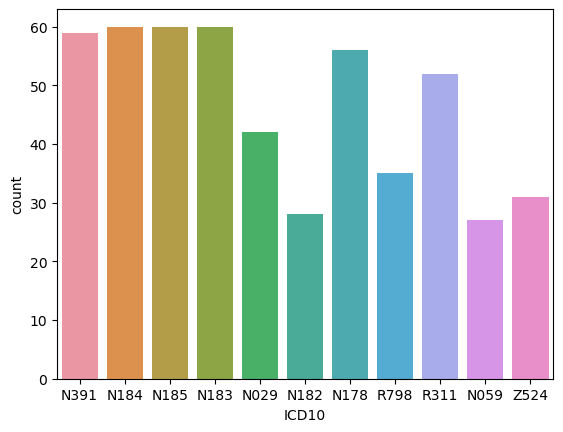

In [53]:
# Plot the count of ICD10 code
sns.countplot(data=undersampled_df, x=undersampled_df['ICD10'], order=label_dict)

In [54]:
texts = undersampled_df['record']
labels = undersampled_df['ICD10']

In [55]:
undersampled_df.shape

(510, 6)

In [29]:
# undersampled_df.record = undersampled_df.record.str.replace('[#,@,&]', '')
# # Remove digits
# undersampled_df.record = undersampled_df.record.str.replace('\d*','')
# #Remove www
# undersampled_df.record = undersampled_df.record.str.replace('w{3}','')
# # remove urls
# undersampled_df.record = undersampled_df.record.str.replace("http\S+", "")
# # remove multiple spaces with single space
# undersampled_df.record = undersampled_df.record.str.replace('\s+', ' ')
# #remove all single characters
# undersampled_df.record = undersampled_df.record.str.replace(r'\s+[a-zA-Z]\s+', '')
# # 여러번 반복되는 문자 하나만 표현
# undersampled_df.record = undersampled_df.record.str.replace('=+', ' ')

In [57]:
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r" , ", " ", string)
    return string.strip().lower()


def preprocess_data(sentences):
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    tokenize_sentences = []
    word_list_dict = {}
    
    for sentence in sentences:
        temp = clean_str(sentence)
        word_list_temp = temp.split()
        doc_words = []
        for word in word_list_temp:
            if word not in stop_words:
                doc_words.append(word)
                word_list_dict[word] = 1
        doc_word_result = ' '.join(doc_words)
        tokenize_sentences.append(doc_word_result)
    word_list = list(word_list_dict.keys())
    
    return tokenize_sentences, word_list

tokenize_texts, word_list = preprocess_data(texts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KLab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
tokenize_texts

['microscopic hematuria proteinuria proteinuria hematuria pediatric inner circle acei arb drug take interruption internal circle blood pressure adjustment',
 'azotemia type dm cr egfr bp',
 'evaluation renal function htn lmc lmc cr egfr reduction anorexia wt loss',
 '',
 'microscopic hematuria proteinuria year proteinuria microscope hematuria internal medicine protein ob urinary sx foam gross hematuria psa abdominal ultrasound',
 'edema edema occurrence tgs tft drinking soju bottle spring bicycle daily bp bw nic',
 'azotemia acute cholecystem surgery hospitalization ptgbd',
 'microscope hematuria rbc hpf room sight tinnitus prostate calcification frequency creat egfr nocturia time one night edemacyst bosniak c',
 'reminery proteinuria htn type dm ich cr bp',
 'kt type dm chronic hepatitis barracrudes',
 'azotemia type dm htn cr egfr chf hospitalization discharge',
 'proteinuria hematuria edema , gh proteenuria hematuria lmc cr egfr prot rbc hpf',
 'kt esrd dmn peritoneum dialysis husba

In [85]:
# 레이블 인코딩
label2idx = {label: idx for idx, label in enumerate(set(labels))}
encoded_labels = [label2idx[label] for label in labels]
# encoded_labels = torch.LongTensor(encoded_labels)

In [86]:
# type(tokenize_texts)
type(encoded_labels)

list

In [87]:
target_df = pd.DataFrame({'texts': tokenize_texts, 'labels': encoded_labels})

In [186]:
target_df.replace('', np.nan, inplace=True)
target_df = target_df.dropna()

In [193]:
target_df.head(10)

,texts,labels
0,microscopic hematuria proteinuria proteinuria ...,9
1,azotemia type dm cr egfr bp,7
2,evaluation renal function htn lmc lmc cr egfr ...,1
4,microscopic hematuria proteinuria year protein...,9
5,edema edema occurrence tgs tft drinking soju b...,2
6,azotemia acute cholecystem surgery hospitaliza...,1
7,microscope hematuria rbc hpf room sight tinnit...,10
8,reminery proteinuria htn type dm ich cr bp,7
9,kt type dm chronic hepatitis barracrudes,3
10,azotemia type dm htn cr egfr chf hospitalizati...,0


In [190]:
X_train, X_temp, y_train, y_temp = train_test_split(target_df['texts'], target_df['labels'], test_size=0.3, random_state=52, stratify=target_df['labels'])
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=73, stratify=y_temp)

In [196]:
X_train[0]

451    cr egfr hb symptoms edema uremia doe know dm h...
397          proteinuria hematuria proteinuria hematuria
157    azotemia thoracic surgery cabg valve op crrt h...
384    proteinuria neurogenic bladder urology rbc rbc...
289    hematuria hematururia discovery ct bladder end...
303    donor evaluation htn year hyperlipidemia drug ...
364    evaluation renal function dm hx mitral stenosi...
327                           proteinuria proteinuria bp
226    proteinuria albuminuria cr egfr hematuria impo...
375              proteinuria proteinuria cr egfr upcr bp
Name: texts, dtype: object

In [197]:
y_train[0]

9

<Axes: xlabel='labels', ylabel='count'>

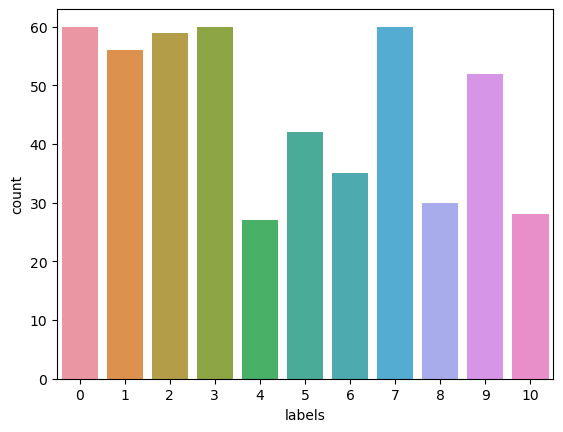

In [201]:
# Plot the count of ICD10 code
sns.countplot(data=target_df, x=target_df['labels'])

In [243]:
# BERT 토크나이저와 모델 불러오기
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"
config = BertConfig.from_pretrained(model_checkpoint)

# num_labels 설정
num_labels = len(label_dict)

# config 수정
config.num_labels = num_labels

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
bertmodel = AutoModel.from_pretrained(model_checkpoint, config=config)
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config)

# # 사용자 정의 분류기 추가
# class CustomClassifier(nn.Module):
#     def __init__(self, num_labels):
#         super(CustomClassifier, self).__init__()
#         self.num_labels = num_labels
#         self.classifier = nn.Linear(model.config.hidden_size, self.num_labels)

#     def forward(self, hidden_states):
#         logits = self.classifier(hidden_states)
#         return logits

class BERTClassifier(nn.Module):
    def __init__(self, bertmodel, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = bertmodel
        self.num_labels = num_labels
        self.classifier = nn.Linear(768, num_labels) # tinybert=312, bert-base=768
        self.dropout = nn.Dropout(0.1)

    
    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert(input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        pooler = output['pooler_output']
        pooler = self.dropout(pooler)
        fc_layer = self.classifier(pooler)
        return fc_layer

# 기존 모델의 분류기를 사용자 정의 분류기로 대체
model = BERTClassifier(bertmodel=bertmodel, num_labels=num_labels)
model.to(device)

loading configuration file config.json from cache at C:\Users\KLab/.cache\huggingface\hub\models--emilyalsentzer--Bio_ClinicalBERT\snapshots\9b5e0380b37eac696b3ff68b5f319c554523971f\config.json
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\KLab/.cache\huggingface\hub\models--emilyalsentzer--Bio_ClinicalBERT\snapshots\9b5e0380b37eac696b3ff68b5f319c5545

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [245]:
print(model.num_labels)

11


In [79]:
# # 데이터 전처리: 텍스트를 인코딩하고 텐서로 변환
# # inputs = []
# input_ids_list = []
# attention_mask_list = []

# max_length = 128

# for text in tokenize_texts:
#     # 각 텍스트를 토큰화하여 tokenizer에 전달하고 결과를 리스트에 추가
#     tokenized_input = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
#     # inputs.append(tokenized_input)
#     input_ids_list.append(tokenized_input['input_ids'])
#     attention_mask_list.append(tokenized_input['attention_mask'])

In [78]:
# max_tensor_size = max(tensor.shape for tensor in input_ids_list)

# print("가장 긴 텐서의 크기:", max_tensor_size)

가장 긴 텐서의 크기: torch.Size([1, 128])


In [99]:
# 텐서로 변환
# input_ids_tensor = torch.cat(input_ids_list, dim=0)
# attention_mask_tensor = torch.cat(attention_mask_list, dim=0)

embedded_data : [[-40.128918  -10.392903 ]
 [ 15.406436   17.601385 ]
 [ 28.684483   18.123854 ]
 ...
 [-11.369315   -2.082267 ]
 [  7.315951   -2.7485607]
 [-13.160764    1.1267109]]


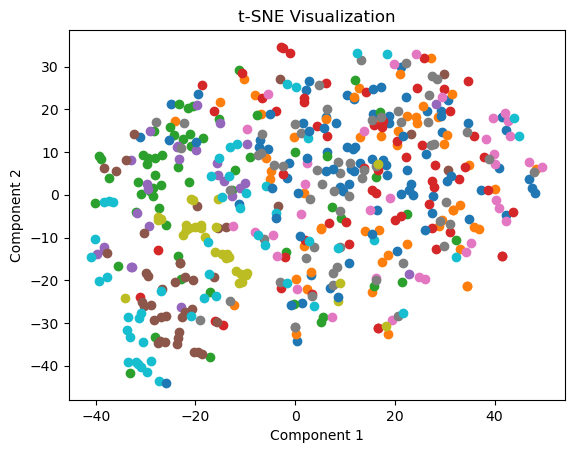

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def convert_tensorlist_to_array(tList):
    data = np.array([])

    for ts in tList:
        arr = ts.numpy().flatten()
        
        if data.size == 0:
            data = arr
        else:
            data = np.vstack((data, arr))
    return data
    
data = convert_tensorlist_to_array(input_ids_list)
labels = np.array(encoded_labels)

# print(data)
# print()
# print(labels)
# t-SNE 적용
tsne = TSNE(n_components=2, perplexity=10)  # 예시로 perplexity 값을 5로 설정
embedded_data = tsne.fit_transform(data)

for label in np.unique(labels):
    mask = labels == label
    plt.scatter(embedded_data[mask, 0], embedded_data[mask, 1], label=f'Label {label}')

print(f'embedded_data : {embedded_data}')
# 시각화
# plt.figure(figsize=(8, 6))
# plt.scatter(embedded_data[:, 0], embedded_data[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [208]:
SEQ_LEN = 128

train_encoding = tokenizer.batch_encode_plus(
  list(X_train),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
)

test_encoding = tokenizer.batch_encode_plus(
  list(X_test),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
)

val_encoding = tokenizer.batch_encode_plus(
  list(X_val),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
)

In [82]:
# # 데이터셋 생성
# dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, encoded_labels)

# # 하이퍼파라미터 설정
# batch_size = 32
# learning_rate = 5e-5

# # 데이터로더 생성
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [216]:
type(y_train)

pandas.core.series.Series

In [223]:
def loadData(prep_df, batch_size, sampler):

    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(train_encoding['input_ids'])
train_mask = torch.tensor(train_encoding['attention_mask'])
train_token_ids = torch.tensor(train_encoding['token_type_ids'])
train_y = torch.tensor(y_train.values)
# train_onehot_y = torch.tensor(y_train_dense, requires_grad=True)
# train_y = torch.argmax(train_onehot_y, dim=-1)

test_seq = torch.tensor(test_encoding['input_ids'])
test_mask = torch.tensor(test_encoding['attention_mask'])
test_token_ids = torch.tensor(test_encoding['token_type_ids'])
test_y = torch.tensor(y_test.values)
# test_onehot_y = torch.tensor(y_test_dense)
# test_y = torch.argmax(test_onehot_y, dim=-1)

val_seq = torch.tensor(val_encoding['input_ids'])
val_mask = torch.tensor(val_encoding['attention_mask'])
val_token_ids = torch.tensor(val_encoding['token_type_ids'])
val_y = torch.tensor(y_val.values)
# val_onehot_y = torch.tensor(y_val_dense)
# val_y = torch.argmax(val_onehot_y, dim=-1)

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, train_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, test_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, len(val_data), val_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the test set', len(testdata))
print('Number of data in the validation set', len(valdata))

Number of data in the train set 12
Number of data in the test set 3
Number of data in the validation set 1


In [246]:
from transformers import Trainer, TrainingArguments

# 학습 인자 설정
training_args = TrainingArguments(
    output_dir="D:\\sample\\model\\BERT_results.txt",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_dir="D:\\sample\\model\\BERT_logs.txt",
)

# 트레이너 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=traindata,
    eval_dataset=testdata,
    compute_metrics=lambda pred: {"accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(axis=1))},
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [247]:
#compute the class weights
class_wts = compute_class_weight(classes=label_dict, y=target_df['labels'], class_weight='balanced')

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
criterion = nn.CrossEntropyLoss(weight=weights)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [261]:
label_dict

array([ 9,  7,  1,  2, 10,  3,  0,  6,  8,  4,  5], dtype=int64)

In [249]:
weights

tensor([0.8899, 0.7712, 0.8263, 0.7843, 1.6526, 0.7712, 0.7712, 1.3221, 1.5424,
        1.7138, 1.1017], device='cuda:0')

In [225]:
# 학습
epochs = 10
for epoch in range(epochs):
    
    model.train()
    for step, batch in enumerate(traindata):
        input_ids, attention_mask, labels = batch
        
        labels = labels.long()
        # labels = torch.argmax(labels, dim=1)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # 검증
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in testdata:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total
    print(f'Epoch {epoch+1}/{epochs}, Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

ValueError: too many values to unpack (expected 3)

In [ ]:
def train_model(epochs, early_stopping, model, optimizer, criterion, features, adj, labels, idx_train, idx_val, show_result = True):
    val_loss = []
    for epoch in range(epochs):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        _, output= model(features, adj)
        loss_train = criterion(output[idx_train], labels[idx_train])
        acc_train = cal_accuracy(output[idx_train], labels[idx_train])
        
        loss_train.backward()
        optimizer.step()

        model.eval()
        _, output = model(features, adj)

        loss_val = criterion(output[idx_val], labels[idx_val])
        val_loss.append(loss_val.item())
        acc_val = cal_accuracy(output[idx_val], labels[idx_val])
        if show_result:
            print(  'Epoch: {:04d}'.format(epoch+1),
                    'loss_train: {:.4f}'.format(loss_train.item()),
                    'acc_train: {:.4f}'.format(acc_train),
                    'loss_val: {:.4f}'.format(loss_val.item()),
                    'acc_val: {:.4f}'.format(acc_val),
                    'time: {:.4f}s'.format(time.time() - t))
        
        if epoch > early_stopping and np.min(val_loss[-early_stopping:]) > np.min(val_loss[:-early_stopping]) :
            if show_result:
                print("Early Stopping...")
            break

In [290]:
from sklearn.metrics import accuracy_score

def calc_accuracy(predictions, labels):
    pred = torch.argmax(predictions,-1).cpu().tolist()
    lab = labels.cpu().tolist()
    print(f'pred : {pred}')
    print(f'label : {lab}')
    return accuracy_score(lab,pred)

In [291]:
# function to train the bert model
def trainBERT():

    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0
    avg_loss, avg_accuracy = 0, 0
    
    # empty list to save model predictions
    total_preds=[]
    
    # iterate over batches
    for step, batch in enumerate(traindata):

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]
            
        sent_id, mask, token_type_ids, labels = batch

        labels = labels.long()
        
        # clear previously calculated gradients
        model.zero_grad()
        
        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)
        
        # top_values, top_indices = torch.topk(preds, k=5, dim=1)
        
        # print(f"preds : {preds} --- {top_values} --- {top_indices} --- {labels}")
        
        # compute the loss between actual and predicted values
        loss = criterion(preds, labels)
        # print(f"loss : {loss}")
        
        # add on to the total loss
        total_accuracy += calc_accuracy(preds, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        
        # backward pass to calculate the gradients
        loss.requires_grad_(True)
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update parameters
        optimizer.step()
        
        # # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # # append the model predictions
        total_preds.append(preds)
        # print(f"total_preds : {total_preds}")
        torch.cuda.empty_cache()

    print(f"total_accuracy : {total_accuracy}")
    print(f"total_loss : {total_loss}")
    print(f"len(traindata) : {len(traindata)}")
    
    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)
    avg_accuracy = total_accuracy / len(traindata)
    
    # print(f"total_preds : {total_preds}")
    
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, avg_accuracy, total_preds

In [292]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")
    t0 = time.time()

    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0
    avg_loss, avg_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(testdata):
        
        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        labels = labels.long()
        # labels = torch.argmax(labels, dim=1)
        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = criterion(preds, labels)

            total_accuracy += calc_accuracy(preds, labels)
            total_loss += loss.item()
            
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the test loss of the epoch
    avg_loss = total_loss / len(testdata)
    avg_accuracy = total_accuracy / len(traindata)
    
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_accuracy, total_preds

In [ ]:
# Train the model
    train_model(epochs, early_stopping, model, optimizer, criterion, features, adj, labels, idx_train, idx_val)

    # Test
    if not easy_copy:
        print("Predicting on test set.") 
    model_weights_list = get_weights_hidden(model,features,adj,train_size)
    
    print(f'test_emb : {len(test_emb)}')
    print(f'tokenized_test_edge : {tokenized_test_edge.shape}')
    print(f'model_weights_list : {len(model_weights_list)}')
    
    test_result = test_model(model, test_emb, tokenized_test_edge, model_weights_list, device)

In [293]:
# set initial loss to infinite
best_test_loss = float('inf')

# Empty lists to store training and test loss of each epoch
train_losses=[]
test_losses=[]
train_acc=[]
test_acc=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_acc, _ = trainBERT()

    #evaluate model
    test_loss, test_acc, _ = evaluate()

    print('\n Done for epoch {} -- train accuracy : {} -- train loss : {} -- test accuracy : {} -- test loss : {}'.format(epoch + 1, train_acc, train_loss, test_acc, test_loss))
    
    #save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'D:\\sample\\content2\\bert_weights_5.pt') # Save model weight's (you can also save it in .bin format)

    # append training and validation loss
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')


 Epoch 1 / 10
Training...
pred : [7, 7, 9, 9, 0, 9, 0, 9, 8, 9, 7, 9, 7, 8, 9, 8, 9, 7, 7, 7, 9, 9, 8, 9, 9, 9, 7, 7, 9, 8, 9, 9]
label : [10, 2, 3, 5, 0, 2, 0, 7, 8, 9, 1, 2, 1, 5, 5, 9, 9, 3, 7, 7, 2, 2, 5, 6, 7, 2, 1, 10, 9, 8, 9, 2]
pred : [9, 7, 9, 8, 8, 7, 8, 8, 9, 7, 9, 7, 9, 7, 8, 7, 9, 7, 7, 8, 9, 9, 7, 8, 7, 8, 9, 7, 9, 9, 7, 7]
label : [4, 0, 5, 5, 8, 7, 8, 8, 5, 3, 6, 10, 7, 0, 4, 7, 3, 6, 2, 2, 2, 2, 1, 8, 1, 9, 9, 0, 3, 2, 4, 1]
pred : [9, 8, 9, 9, 9, 9, 7, 9, 7, 7, 9, 7, 9, 7, 7, 7, 9, 7, 9, 8, 9, 7, 7, 8, 7, 9, 9, 9, 7, 9, 9, 9]
label : [5, 8, 5, 5, 9, 9, 4, 2, 1, 4, 2, 3, 9, 3, 6, 1, 0, 10, 6, 2, 6, 1, 3, 3, 7, 1, 9, 9, 3, 4, 2, 0]
pred : [9, 9, 7, 7, 9, 7, 7, 9, 9, 9, 9, 9, 9, 9, 7, 7, 8, 7, 7, 9, 9, 8, 9, 7, 7, 9, 9, 9, 7, 7, 9, 8]
label : [10, 5, 1, 0, 1, 0, 10, 0, 9, 5, 2, 5, 5, 9, 7, 2, 8, 0, 7, 1, 9, 2, 10, 0, 1, 10, 9, 2, 1, 6, 6, 5]
pred : [9, 9, 7, 9, 7, 7, 7, 8, 7, 9, 7, 7, 8, 7, 9, 9, 9, 7, 9, 7, 7, 7, 7, 9, 9, 7, 9, 7, 1, 7, 9, 7]
label : [3, 6, 7, 1, 0, 7